In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [2]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test')]

In [3]:
df = pd.read_csv(path/'train.csv')
df.head(10)

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


In [4]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
pascal = DataBlock(get_x = get_x, get_y = get_y)
dsets = pascal.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/001640.jpg'), ['car', 'person'])

In [5]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [6]:
pascal = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                    splitter=splitter,
                    get_x = get_x,
                    get_y=get_y,
                    item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = pascal.dataloaders(df)

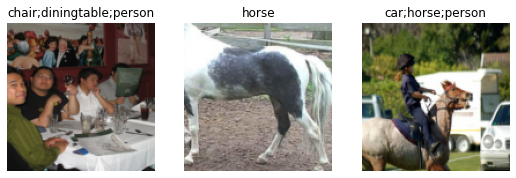

In [7]:
dls.show_batch(nrows=1, ncols=3)

In [8]:
learn = cnn_learner(dls, resnet50)

In [9]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape
activs[0]

tensor([ 3.7577,  3.0931,  0.3739,  0.7204,  0.3188,  1.5112, -3.9765,  2.3217,
        -5.8092, -0.1275,  1.8426,  0.5675, -3.7657,  0.0240,  3.0110, -3.3489,
        -1.4429,  5.7983,  0.2065, -0.7233], grad_fn=<SelectBackward>)

In [10]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0507, grad_fn=<AliasBackward>)

In [11]:
learn = cnn_learner(dls, resnet50 ,metrics = PrecisionMulti(sigmoid = False, thresh = 0.5))
learn.fine_tune(7, base_lr = 3e-3, freeze_epochs = 4)

epoch,train_loss,valid_loss,precision_score,time
0,0.931505,0.696815,0.212017,00:26
1,0.819251,0.555802,0.285405,00:23
2,0.601883,0.213051,0.670455,00:23
3,0.359627,0.126288,0.828265,00:23


epoch,train_loss,valid_loss,precision_score,time
0,0.134731,0.112473,0.846364,00:29
1,0.121286,0.112545,0.847352,00:28
2,0.108411,0.113000,0.822141,00:28
3,0.091322,0.109929,0.861959,00:28
4,0.075633,0.105164,0.851408,00:28
5,0.062089,0.105751,0.852680,00:28
6,0.053619,0.106218,0.857372,00:29


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


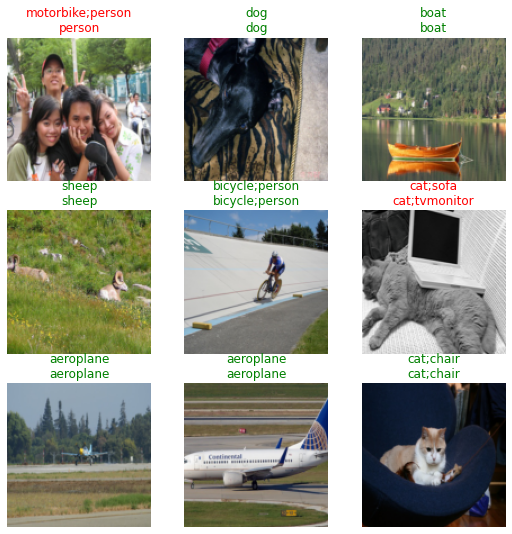

In [12]:
learn.show_results()